In [1]:
rm(list = ls())
if (!requireNamespace("BiocManager", quietly = TRUE))
install.packages("BiocManager")
BiocManager::install("edgeR")
BiocManager::install("clusterProfiler")
BiocManager::install("org.Hs.eg.db")
BiocManager::install("glmnet")
BiocManager::install("survminer")
library(dplyr)
library(edgeR)
library(limma)
library(stringr)
library(ggplot2)
library(clusterProfiler)
library(org.Hs.eg.db)
library(survival)
library(survminer)
library(glmnet)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”
Installation paths not writeable, unable to update packages
  path: /usr/lib/R/library
  packages:
    boot, lattice, rpart, spatial
  path: /usr/local/lib/R/site-library
  packages:
    askpass, bslib, cpp11, curl, dbplyr, dplyr, evaluate, fansi, fontawesome,
    fs, gargle, ggplot2, gtable, htmltools, httr, igraph, knitr, labeling,
    lubridate, magick, pbdZMQ, prettyunits, purrr, ragg, rematch, rmarkdown,
    sass, systemfonts, textshaping, tinytex, utf8, uuid, vctrs, vroom, withr,
    xfun

Old packages: 'credentials', 'gert', 'httpuv', 'markdown', 'openssl',
  'promises', 'shiny'

'g

In [2]:
color_up <- rgb(184,002,000,maxColorValue = 255)
color_down <- rgb(231,175,048,maxColorValue = 255)

color_BP <- rgb(225,215,196,maxColorValue = 255)
color_MF <- rgb(037,130,121,maxColorValue = 255)
color_CC <- rgb(072,068,095,maxColorValue = 255)

In [3]:
GO_top <- function(data,num){
  GO_BP <- data[data$ONTOLOGY == "BP",]
  GO_BP <- GO_BP[order(GO_BP$qvalue),]
  GO_MF <- data[data$ONTOLOGY == "MF",]
  GO_MF <- GO_MF[order(GO_MF$qvalue),]
  GO_CC <- data[data$ONTOLOGY == "CC",]
  GO_CC <- GO_CC[order(GO_CC$qvalue),]
  res <- rbind(GO_BP[1:num,],GO_MF[1:num,],GO_CC[1:num,])
  return(res)
}

In [4]:
enrichment_factor <- function(GeneRatio,BgRatio){
  a <- str_split(GeneRatio,"/")
  a <- t(as.data.frame(a))
  a <- as.numeric(a[,1])/as.numeric(a[,2])
  b <- str_split(BgRatio,"/")
  b <- t(as.data.frame(b))
  b <- as.numeric(b[,1])/as.numeric(b[,2])
  return(a/b)
}

In [5]:
#data insert
exp <- read.table("TCGA-GBM.htseq_fpkm-uq.tsv", header=T,sep = "\t",row.names = 1)
ID <- read.table("gencode.v22.annotation.gene.probeMap", header=T, sep = "\t")
pdata <- data.frame(sample=colnames(exp),
                    group=ifelse(substr(colnames(exp),14,14)=="0","tumor","normal"))
head(exp)

,TCGA.06.0878.01A,TCGA.26.5135.01A,TCGA.06.5859.01A,TCGA.06.2563.01A,TCGA.27.1834.01A,TCGA.28.5207.01A,TCGA.14.0871.01A,TCGA.16.1045.01B,TCGA.32.2632.01A,TCGA.06.0156.01A,⋯,TCGA.19.5960.01A,TCGA.41.5651.01A,TCGA.27.2521.01A,TCGA.28.2513.01A,TCGA.06.0743.01A,TCGA.76.4932.01A,TCGA.08.0386.01A,TCGA.06.0749.01A,TCGA.06.0139.01A,TCGA.27.1831.01A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268.2,14.48288,12.02771,12.09509,13.75609,14.254343,13.69981,14.77365,10.65859,10.49686,14.48764,⋯,15.43031,14.09861,12.22447,10.62569,15.157717,13.18107,13.92696,14.25121,11.46329,15.39229
ENSG00000270112.3,10.86865,12.96473,13.23419,10.61799,8.653561,10.15968,10.11814,12.33213,10.73477,11.39395,⋯,11.37085,12.06503,10.28281,10.68314,9.140903,13.36727,9.78364,11.70172,10.19956,12.14107
ENSG00000167578.15,16.57162,16.75191,17.06651,17.04936,16.334255,16.43982,15.35306,16.22543,16.99045,16.57789,⋯,15.48034,15.56093,16.94156,17.27899,17.958113,16.80565,16.23217,18.16828,17.43038,17.92471
ENSG00000273842.1,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,⋯,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
ENSG00000078237.5,17.38209,17.10721,17.95596,17.62433,16.850173,16.83018,16.41533,16.84142,17.53378,17.05805,⋯,16.37973,16.76334,16.75980,17.23340,16.914482,17.49001,15.98278,17.04933,18.08350,18.19469
ENSG00000146083.10,17.34150,18.13993,17.85098,17.44056,17.638904,17.19665,18.81840,17.45965,17.30671,17.66480,⋯,18.43231,18.30251,17.23559,17.27733,17.641505,17.19799,17.34261,17.45892,17.69670,15.91243


In [6]:
#Different gene identification
group_list <- pdata$group
design <- model.matrix(~0+factor(group_list))
colnames(design)<-levels(factor(group_list))
rownames(design)<-pdata$sample
contrast.matrix<-makeContrasts(paste0(c("tumor","normal"),collapse = "-"),levels = design)
fit <- lmFit(exp,design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)
DEG <- topTable(fit2, coef=1, n=Inf) 

Warning message:
“Zero sample variances detected, have been offset away from zero”


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


png 
  2

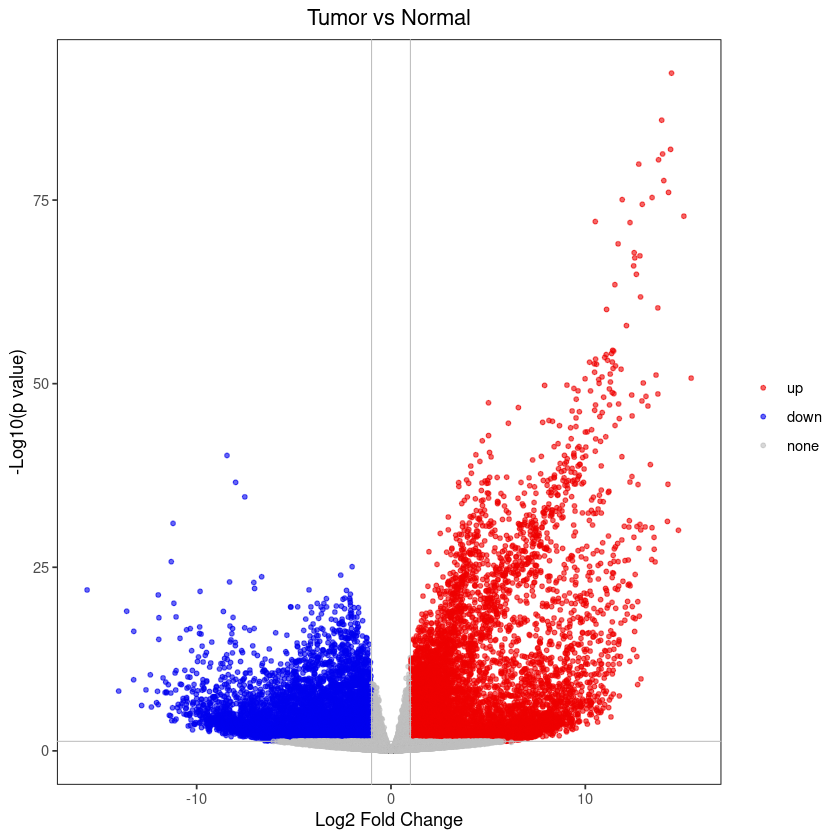

In [7]:
# vocalno plot mapping

# DEG$gene <- rownames(DEG)
DEG[which(DEG$P.Value<0.05 & DEG$logFC <=-1),'sig']<-'down'
DEG[which(DEG$P.Value<0.05 & DEG$logFC >=1),'sig']<-'up'
DEG[which(DEG$P.Value>=0.05 | abs(DEG$logFC) < 1),'sig']<-'none'
p <- ggplot(DEG, aes(x = logFC, y = -log10(P.Value), color = sig)) +
  geom_point(alpha = 0.6, size = 1) +
  scale_colour_manual(values = c('red2', 'blue2', 'gray'), limits = c('up', 'down', 'none')) +
  theme(panel.grid = element_blank(), panel.background = element_rect(color = 'black', fill = 'transparent'), plot.title = element_text(hjust = 0.5)) +
  theme(legend.key = element_rect(fill = 'transparent'), legend.background = element_rect(fill = 'transparent'), legend.position = c(0.9, 0.93)) +
  geom_vline(xintercept = c(-1, 1), color = 'gray', size = 0.3) +
  geom_hline(yintercept = -log(0.05, 10), color = 'gray', size = 0.3) +
  #xlim(-5, 5) + ylim(0, 8) +
  labs(x = 'Log2 Fold Change', y = '-Log10(p value)', color = '', title = 'Tumor vs Normal')+
  theme(plot.title = element_text(hjust = 0.5), legend.position="right", legend.title = element_blank())
  # geom_text_repel(
  #   data = subset(DEG, DEG$P.Value < 0.0001 & abs(DEG$logFC) >= 2.5),
  #   aes(label = gene),
  #   size = 3,
  #   box.padding = unit(0.5, "lines"),
  #   point.padding = unit(0.8, "lines"), segment.color = "black", show.legend = FALSE )
p
pdf("01.DEG_Volcano.pdf")
p
dev.off()

In [8]:
## filter result
DEG_filter <- filter(DEG, abs(DEG$logFC)>1&DEG$P.Value<0.05)
head(DEG_filter)
## ID transformingc
DEG_filter$id <- rownames(DEG_filter)
DEG_filter <- left_join(DEG_filter,ID,by="id")
ID_trans <- bitr(DEG_filter$gene,fromType = "SYMBOL",toType = "ENTREZID",OrgDb = org.Hs.eg.db)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000250568.1,14.43685,14.01960,42.48984,5.238210e-93,3.168226e-88,199.9081,up
ENSG00000231878.1,13.93151,13.52886,38.64375,1.333678e-86,4.033243e-82,185.7108,up
ENSG00000213867.4,14.38896,13.97309,36.40251,1.249548e-82,2.519213e-78,176.8601,up
ENSG00000228938.3,13.97790,13.57392,36.05801,5.296715e-82,8.009031e-78,175.4592,up
ENSG00000253173.3,13.76869,13.37075,35.62620,3.286776e-81,3.975882e-77,173.6876,up
ENSG00000249921.2,12.75107,12.38254,35.30712,1.280298e-80,1.290604e-76,172.3671,up


'select()' returned 1:many mapping between keys and columns

Warning message in bitr(DEG_filter$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“37.14% of input gene IDs are fail to map...”


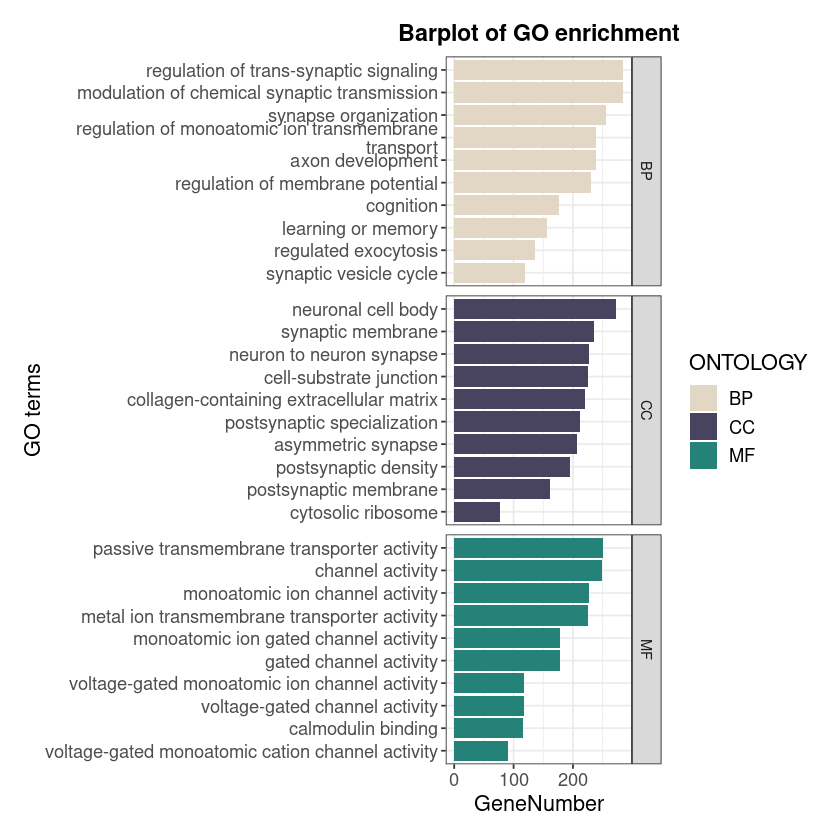

In [12]:
# Enrichment analyse 
## GO Enrichment
enrichGO_res<- enrichGO(ID_trans$ENTREZID,
                        OrgDb = org.Hs.eg.db,
                        keyType = "ENTREZID",
                        ont = "ALL",
                        pvalueCutoff = 0.2,
                        pAdjustMethod = "BH",
                        qvalueCutoff = 0.2)
GO_res <- as.data.frame(enrichGO_res)
GO_res <- GO_res[GO_res$qvalue<0.05,]
GO <- GO_top(GO_res,10)
GO$foldEnrich <- enrichment_factor(GO$GeneRatio,GO$BgRatio)

go_bar <- ggplot(data = GO, # import data being used in ploting
                 aes(x = reorder(Description,Count), y = Count,fill = ONTOLOGY))+ #horizontal coordinate filling and colour clssfication
  geom_bar(stat = "identity",width = 0.9)+ #draw the diagram and set the width
  scale_fill_manual(values=c(color_BP,
                             color_CC,
                             color_MF))+
  facet_grid(ONTOLOGY~.,scales = "free",space = "free")+
  coord_flip()+theme_bw()+ #delete backgroud colour
  scale_x_discrete(labels = function(x) str_wrap(x,width = 50))+ #jump to next line if the name is too long
  labs(x = "GO terms",y = "GeneNumber",title = "Barplot of GO enrichment")+ #set title
  theme(axis.title = element_text(size = 13), #title font size
        axis.text = element_text(size = 11), # label font size
        plot.title = element_text(size = 14,hjust = 0.5,face = "bold"), #title setting
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 11), 
        plot.margin = unit(c(0.5,0.5,0.5,0.5),"cm")) #plot side distance
go_bar
ggsave(go_bar,filename = "02.GO_Barplot.pdf",width = 9,height = 9)cc

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Reading KEGG annotation online: "https://rest.kegg.jp/conv/ncbi-geneid/hsa"...



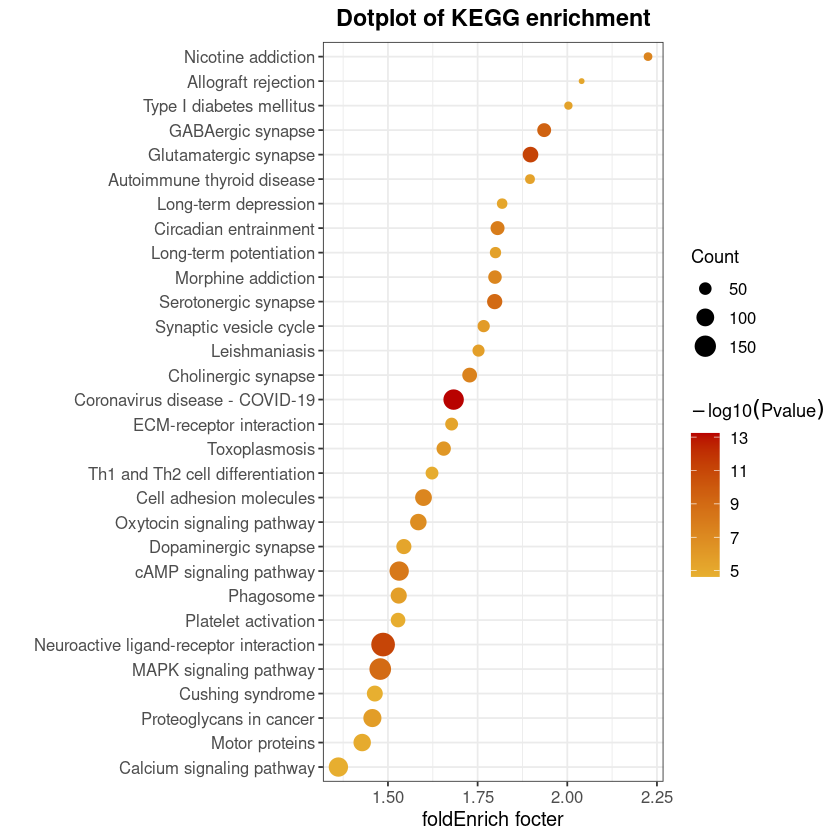

In [13]:
## KEGG Enrichment
kegg <- enrichKEGG(
   gene = ID_trans$ENTREZID,  
   keyType = 'ncbi-geneid',  #Gene type
   organism = 'hsa',  #hsa means Human being
   pvalueCutoff = 0.2,  #P-value range and cut-off value
   qvalueCutoff = 0.2)  #q-value range and cut-off value

KEGG_res <- as.data.frame(kegg)
KEGG_res <- KEGG_res[1:30,]
KEGG_res$foldEnrich <- enrichment_factor(KEGG_res$GeneRatio,KEGG_res$BgRatio)

p = ggplot(data = KEGG_res,aes(x = foldEnrich, y = reorder(Description,foldEnrich)))+
  geom_point(aes(size = Count,color = -log10(pvalue)))+
  theme_bw()+
  scale_colour_gradient(low = color_down,high = color_up)+
  scale_y_discrete(labels = function(x) str_wrap(x,width = 60))+
  labs(x = "foldEnrich focter",y = "",title = "Dotplot of KEGG enrichment",
       color = expression(-log10(Pvalue)),size = "Count")+
  theme(axis.title = element_text(size = 12),axis.text = element_text(size = 10),
        plot.title = element_text(size = 14,hjust = 0.5,face = "bold"),
        legend.title = element_text(size = 11),legend.text = element_text(size = 10))
p
ggsave(p,filename = "02.KEGG_dotplot.pdf",width = 9,height = 9)
c

In [8]:
#single factor cox regression
exp <- exp[DEG_filter$id,]
cli <- read.table("TCGA-GBM.survival.tsv", header=T, sep = "\t")
cli <- cli[,c(1,2,4)]
exp <- exp[,substr(colnames(exp),14,14)=="0"]
colnames(exp) <- gsub("\\.","-",colnames(exp))
cli <- cli[cli$sample %in% colnames(exp),]

exp <- exp[,cli$sample]


exp <- exp[apply(exp == 0, 1, sum)<100,]

exp <- as.data.frame(t(exp))
for(i in c(1:ncol(exp))){
  exp[,i] <- as.numeric(exp[,i])
}

exp$sample <- rownames(exp)
CoxData <- left_join(cli,exp)
head(CoxData)

Joining with `by = join_by(sample)`


,sample,OS,OS.time,ENSG00000250568.1,ENSG00000231878.1,ENSG00000213867.4,ENSG00000228938.3,ENSG00000253173.3,ENSG00000249921.2,ENSG00000237730.1,⋯,ENSG00000204612.1,ENSG00000255367.1,ENSG00000261646.1,ENSG00000268529.1,ENSG00000087116.12,ENSG00000125409.11,ENSG00000266411.1,ENSG00000205325.1,ENSG00000233435.1,ENSG00000269956.1
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TCGA-19-2624-01A,1,5,13.62306,14.07049,12.90152,13.45468,14.27769,10.57493,12.53223,⋯,8.124717,9.038159,9.677238,8.791791,13.62610,12.11377,13.022325,0.000000,0.000000,11.73109
2,TCGA-41-4097-01A,1,6,15.05346,13.69739,14.08083,14.34453,13.77530,12.63404,13.42202,⋯,10.010843,10.511268,0.000000,9.680197,16.40878,12.95773,0.000000,7.809292,13.393208,11.79786
3,TCGA-06-2569-01A,0,13,14.61965,13.77170,15.63230,14.18824,13.49350,12.03040,14.40317,⋯,0.000000,8.326066,0.000000,0.000000,14.57544,12.72174,0.000000,0.000000,9.091527,11.40068
4,TCGA-06-0219-01A,1,22,14.25748,14.84242,15.75132,15.57446,15.11673,13.25298,15.78940,⋯,0.000000,8.810588,0.000000,9.562402,12.37115,15.17084,10.987468,0.000000,9.576579,10.78724
5,TCGA-41-2571-01A,1,26,12.70905,14.49025,15.32115,14.44739,14.13113,12.28951,14.70962,⋯,0.000000,11.751070,8.901881,0.000000,14.64678,12.51698,11.982860,0.000000,10.349150,11.56025
6,TCGA-06-0750-01A,1,28,13.83227,13.56925,14.23021,14.19436,13.19153,12.07304,13.40936,⋯,0.000000,9.536083,0.000000,10.872991,15.58661,15.03848,9.131136,0.000000,0.000000,10.51417


In [15]:
##Single factor cox regression analyse
#Set p value
pfilter <- 0.05  
#creat new data frame
uniresult <- data.frame()  
#Use for-loop to do the single cox regression to each genes inc a row
#For those gene that has P-value＜0.05, import the result in to the dataframe 'uniresult'
for(i in colnames(CoxData[,4:(ncol(CoxData))])){
  # i <- "ENSG00000248462.1"
  message(paste(i," is computing"))
  unicox <- coxph(Surv(time = OS.time, event = OS) ~ CoxData[,i], data = CoxData)  
  unisum<- summary(unicox)   
  pvalue <- round(unisum$coefficients[,5],3)
  if(unisum$coefficients[,2] != "NA"){
    if(pvalue<pfilter){ 
      uniresult <- rbind(uniresult,
                         cbind(gene=i,
                               HR=unisum$coefficients[,2],
                               L95CI=unisum$conf.int[,3],
                               H95CI=unisum$conf.int[,4],
                               pvalue=unisum$coefficients[,5]
                         )
      )
    }
  }
  
} 

ENSG00000250568.1  is computing

ENSG00000231878.1  is computing

ENSG00000213867.4  is computing

ENSG00000228938.3  is computing

ENSG00000253173.3  is computing

ENSG00000249921.2  is computing

ENSG00000237730.1  is computing

ENSG00000224953.1  is computing

ENSG00000213774.3  is computing

ENSG00000235251.2  is computing

ENSG00000224820.2  is computing

ENSG00000227854.1  is computing

ENSG00000196604.10  is computing

ENSG00000240023.1  is computing

ENSG00000259394.2  is computing

ENSG00000226082.2  is computing

ENSG00000229965.1  is computing

ENSG00000235644.1  is computing

ENSG00000229985.2  is computing

ENSG00000216412.4  is computing

ENSG00000213539.4  is computing

ENSG00000227850.1  is computing

ENSG00000235115.3  is computing

ENSG00000213851.3  is computing

ENSG00000230203.1  is computing

ENSG00000230228.2  is computing

ENSG00000242083.2  is computing

ENSG00000239198.1  is computing

ENSG00000255074.1  is computing

ENSG00000240125.1  is computing

ENSG00000

ENSG00000234354.3  is computing

ENSG00000219149.4  is computing

ENSG00000248699.1  is computing

ENSG00000213183.3  is computing

ENSG00000237493.3  is computing

ENSG00000233287.1  is computing

ENSG00000234985.2  is computing

ENSG00000248873.1  is computing

ENSG00000268412.2  is computing

ENSG00000242814.2  is computing

ENSG00000261557.1  is computing

ENSG00000234648.1  is computing

ENSG00000212695.5  is computing

ENSG00000233668.1  is computing

ENSG00000219487.2  is computing

ENSG00000253506.2  is computing

ENSG00000243256.1  is computing

ENSG00000259917.1  is computing

ENSG00000230383.1  is computing

ENSG00000227173.1  is computing

ENSG00000235297.3  is computing

ENSG00000259612.1  is computing

ENSG00000220267.1  is computing

ENSG00000214019.2  is computing

ENSG00000243746.1  is computing

ENSG00000229161.2  is computing

ENSG00000240759.1  is computing

ENSG00000231351.2  is computing

ENSG00000254387.1  is computing

ENSG00000272196.2  is computing

ENSG000002

ENSG00000253626.3  is computing

ENSG00000106006.6  is computing

ENSG00000188512.6  is computing

ENSG00000258645.2  is computing

ENSG00000270983.1  is computing

ENSG00000213448.3  is computing

ENSG00000249264.1  is computing

ENSG00000214389.2  is computing

ENSG00000233476.3  is computing

ENSG00000251118.1  is computing

ENSG00000214561.3  is computing

ENSG00000277358.1  is computing

ENSG00000196205.8  is computing

ENSG00000178999.11  is computing

ENSG00000265936.1  is computing

ENSG00000214552.4  is computing

ENSG00000235582.2  is computing

ENSG00000204194.1  is computing

ENSG00000123485.10  is computing

ENSG00000244076.1  is computing

ENSG00000251467.1  is computing

ENSG00000139239.7  is computing

ENSG00000271525.1  is computing

ENSG00000232393.1  is computing

ENSG00000213280.2  is computing

ENSG00000213935.3  is computing

ENSG00000185686.16  is computing

ENSG00000273983.1  is computing

ENSG00000105988.6  is computing

ENSG00000236552.2  is computing

ENSG000

ENSG00000232004.1  is computing

ENSG00000228121.1  is computing

ENSG00000216938.3  is computing

ENSG00000110931.17  is computing

ENSG00000237828.1  is computing

ENSG00000213305.3  is computing

ENSG00000235411.1  is computing

ENSG00000256338.2  is computing

ENSG00000243403.1  is computing

ENSG00000090889.11  is computing

ENSG00000263781.3  is computing

ENSG00000228834.1  is computing

ENSG00000233045.1  is computing

ENSG00000213152.5  is computing

ENSG00000228887.3  is computing

ENSG00000237931.1  is computing

ENSG00000236993.2  is computing

ENSG00000237784.1  is computing

ENSG00000214535.3  is computing

ENSG00000225093.1  is computing

ENSG00000105137.11  is computing

ENSG00000253683.1  is computing

ENSG00000173457.9  is computing

ENSG00000242100.2  is computing

ENSG00000230592.2  is computing

ENSG00000229022.1  is computing

ENSG00000106462.9  is computing

ENSG00000234518.2  is computing

ENSG00000225154.2  is computing

ENSG00000238137.2  is computing

ENSG000

ENSG00000234004.4  is computing

ENSG00000224550.1  is computing

ENSG00000180764.13  is computing

ENSG00000258334.1  is computing

ENSG00000123219.11  is computing

ENSG00000219986.2  is computing

ENSG00000234106.3  is computing

ENSG00000239246.3  is computing

ENSG00000111206.11  is computing

ENSG00000263017.1  is computing

ENSG00000228071.4  is computing

ENSG00000256167.1  is computing

ENSG00000206228.4  is computing

ENSG00000256745.1  is computing

ENSG00000218803.1  is computing

ENSG00000166167.16  is computing

ENSG00000129195.14  is computing

ENSG00000128714.5  is computing

ENSG00000058262.8  is computing

ENSG00000089157.14  is computing

ENSG00000213592.4  is computing

ENSG00000224858.5  is computing

ENSG00000225022.1  is computing

ENSG00000171320.13  is computing

ENSG00000007968.6  is computing

ENSG00000103855.16  is computing

ENSG00000251400.1  is computing

ENSG00000146410.10  is computing

ENSG00000241458.1  is computing

ENSG00000160014.15  is computing



ENSG00000232916.1  is computing

ENSG00000213362.3  is computing

ENSG00000238103.4  is computing

ENSG00000088367.19  is computing

ENSG00000213872.3  is computing

ENSG00000225695.1  is computing

ENSG00000158402.17  is computing

ENSG00000257179.1  is computing

ENSG00000270276.2  is computing

ENSG00000249779.1  is computing

ENSG00000218227.3  is computing

ENSG00000023516.8  is computing

ENSG00000268942.2  is computing

ENSG00000132646.9  is computing

ENSG00000165914.13  is computing

ENSG00000240776.1  is computing

ENSG00000156011.15  is computing

ENSG00000137970.7  is computing

ENSG00000227706.3  is computing

ENSG00000117399.12  is computing

ENSG00000204843.11  is computing

ENSG00000234975.6  is computing

ENSG00000198689.8  is computing

ENSG00000197575.6  is computing

ENSG00000143228.11  is computing

ENSG00000125385.9  is computing

ENSG00000165752.15  is computing

ENSG00000169282.16  is computing

ENSG00000240459.2  is computing

ENSG00000235776.2  is computing

E

ENSG00000244398.1  is computing

ENSG00000225558.1  is computing

ENSG00000240210.3  is computing

ENSG00000151150.19  is computing

ENSG00000198826.9  is computing

ENSG00000100307.11  is computing

ENSG00000230216.1  is computing

ENSG00000113595.13  is computing

ENSG00000136895.17  is computing

ENSG00000181524.6  is computing

ENSG00000166881.8  is computing

ENSG00000240975.1  is computing

ENSG00000107130.8  is computing

ENSG00000213891.3  is computing

ENSG00000133136.4  is computing

ENSG00000178429.9  is computing

ENSG00000165983.13  is computing

ENSG00000141971.11  is computing

ENSG00000176933.5  is computing

ENSG00000258476.4  is computing

ENSG00000041982.13  is computing

ENSG00000259032.2  is computing

ENSG00000109756.7  is computing

ENSG00000149554.11  is computing

ENSG00000186871.6  is computing

ENSG00000198785.4  is computing

ENSG00000243759.1  is computing

ENSG00000059758.6  is computing

ENSG00000232273.1  is computing

ENSG00000156869.11  is computing

E

ENSG00000244073.1  is computing

ENSG00000130758.6  is computing

ENSG00000231549.1  is computing

ENSG00000188523.7  is computing

ENSG00000260266.1  is computing

ENSG00000250133.2  is computing

ENSG00000068383.17  is computing

ENSG00000242661.1  is computing

ENSG00000163597.13  is computing

ENSG00000239887.4  is computing

ENSG00000166263.12  is computing

ENSG00000231341.1  is computing

ENSG00000258090.1  is computing

ENSG00000231017.1  is computing

ENSG00000236792.1  is computing

ENSG00000229067.1  is computing

ENSG00000148606.11  is computing

ENSG00000224837.1  is computing

ENSG00000233615.1  is computing

ENSG00000138792.8  is computing

ENSG00000280800.1  is computing

ENSG00000257576.1  is computing

ENSG00000225580.2  is computing

ENSG00000114988.10  is computing

ENSG00000112773.14  is computing

ENSG00000215835.2  is computing

ENSG00000197860.8  is computing

ENSG00000260837.1  is computing

ENSG00000240342.3  is computing

ENSG00000109466.12  is computing

ENS

ENSG00000070756.12  is computing

ENSG00000255014.1  is computing

ENSG00000139793.17  is computing

ENSG00000157152.15  is computing

ENSG00000115128.6  is computing

ENSG00000183474.14  is computing

ENSG00000134901.11  is computing

ENSG00000186862.16  is computing

ENSG00000227747.2  is computing

ENSG00000051341.12  is computing

ENSG00000173611.16  is computing

ENSG00000266876.1  is computing

ENSG00000198929.11  is computing

ENSG00000234558.1  is computing

ENSG00000057757.8  is computing

ENSG00000160785.12  is computing

ENSG00000237008.2  is computing

ENSG00000099365.8  is computing

ENSG00000267301.1  is computing

ENSG00000119698.10  is computing

ENSG00000116604.16  is computing

ENSG00000142875.18  is computing

ENSG00000241923.2  is computing

ENSG00000114978.16  is computing

ENSG00000243071.1  is computing

ENSG00000150433.8  is computing

ENSG00000123364.4  is computing

ENSG00000240003.2  is computing

ENSG00000234192.1  is computing

ENSG00000153574.8  is computi

ENSG00000108262.14  is computing

ENSG00000256084.1  is computing

ENSG00000184156.14  is computing

ENSG00000165813.15  is computing

ENSG00000124092.11  is computing

ENSG00000219559.1  is computing

ENSG00000138834.11  is computing

ENSG00000123609.9  is computing

ENSG00000273079.3  is computing

ENSG00000008056.11  is computing

ENSG00000242068.1  is computing

ENSG00000234981.1  is computing

ENSG00000228477.1  is computing

ENSG00000115107.18  is computing

ENSG00000172915.17  is computing

ENSG00000150995.16  is computing

ENSG00000182389.17  is computing

ENSG00000105559.10  is computing

ENSG00000140525.16  is computing

ENSG00000144036.13  is computing

ENSG00000166257.7  is computing

ENSG00000226161.1  is computing

ENSG00000229083.1  is computing

ENSG00000265574.1  is computing

ENSG00000166484.18  is computing

ENSG00000011198.6  is computing

ENSG00000137869.12  is computing

ENSG00000188610.11  is computing

ENSG00000164187.6  is computing

ENSG00000276293.3  is compu

ENSG00000078814.14  is computing

ENSG00000170500.11  is computing

ENSG00000108511.9  is computing

ENSG00000198064.12  is computing

ENSG00000158169.10  is computing

ENSG00000244535.1  is computing

ENSG00000186470.12  is computing

ENSG00000163785.11  is computing

ENSG00000235084.3  is computing

ENSG00000217060.1  is computing

ENSG00000181885.17  is computing

ENSG00000106852.14  is computing

ENSG00000197102.9  is computing

ENSG00000164112.11  is computing

ENSG00000166851.13  is computing

ENSG00000115414.17  is computing

ENSG00000168781.20  is computing

ENSG00000020633.17  is computing

ENSG00000166710.16  is computing

ENSG00000242882.1  is computing

ENSG00000055147.16  is computing

ENSG00000015413.8  is computing

ENSG00000115282.18  is computing

ENSG00000162244.9  is computing

ENSG00000139083.9  is computing

ENSG00000077514.7  is computing

ENSG00000229897.2  is computing

ENSG00000214857.4  is computing

ENSG00000171368.11  is computing

ENSG00000204138.11  is com

ENSG00000178035.10  is computing

ENSG00000268157.1  is computing

ENSG00000115758.11  is computing

ENSG00000235071.1  is computing

ENSG00000101888.10  is computing

ENSG00000132359.12  is computing

ENSG00000244586.1  is computing

ENSG00000103404.13  is computing

ENSG00000174132.8  is computing

ENSG00000146833.14  is computing

ENSG00000213179.4  is computing

ENSG00000226428.1  is computing

ENSG00000249271.2  is computing

ENSG00000230750.1  is computing

ENSG00000185518.10  is computing

ENSG00000196262.12  is computing

ENSG00000135049.14  is computing

ENSG00000129696.11  is computing

ENSG00000213303.3  is computing

ENSG00000198918.7  is computing

ENSG00000197056.8  is computing

ENSG00000127561.13  is computing

ENSG00000175352.9  is computing

ENSG00000143153.11  is computing

ENSG00000235065.1  is computing

ENSG00000242017.1  is computing

ENSG00000137275.12  is computing

ENSG00000139343.9  is computing

ENSG00000197586.11  is computing

ENSG00000016864.15  is comput

ENSG00000162728.4  is computing

ENSG00000134686.15  is computing

ENSG00000130540.12  is computing

ENSG00000227145.1  is computing

ENSG00000267080.4  is computing

ENSG00000241255.1  is computing

ENSG00000138750.13  is computing

ENSG00000233229.1  is computing

ENSG00000260689.2  is computing

ENSG00000232676.1  is computing

ENSG00000186472.18  is computing

ENSG00000233452.5  is computing

ENSG00000101608.11  is computing

ENSG00000168461.11  is computing

ENSG00000078053.15  is computing

ENSG00000240048.1  is computing

ENSG00000114757.17  is computing

ENSG00000130338.11  is computing

ENSG00000144034.13  is computing

ENSG00000147614.3  is computing

ENSG00000134709.9  is computing

ENSG00000038210.12  is computing

ENSG00000112053.12  is computing

ENSG00000143748.16  is computing

ENSG00000138411.9  is computing

ENSG00000185133.12  is computing

ENSG00000139832.4  is computing

ENSG00000147274.13  is computing

ENSG00000156802.11  is computing

ENSG00000167971.15  is comp

ENSG00000120645.10  is computing

ENSG00000106028.9  is computing

ENSG00000257043.1  is computing

ENSG00000134297.6  is computing

ENSG00000134504.11  is computing

ENSG00000181035.12  is computing

ENSG00000164031.15  is computing

ENSG00000219797.2  is computing

ENSG00000133030.18  is computing

ENSG00000275029.1  is computing

ENSG00000214063.9  is computing

ENSG00000124102.4  is computing

ENSG00000276269.1  is computing

ENSG00000186298.10  is computing

ENSG00000174405.12  is computing

ENSG00000103723.11  is computing

ENSG00000233741.1  is computing

ENSG00000136048.12  is computing

ENSG00000224094.1  is computing

ENSG00000102158.18  is computing

ENSG00000168374.9  is computing

ENSG00000168297.14  is computing

ENSG00000225215.1  is computing

ENSG00000260936.1  is computing

ENSG00000180879.12  is computing

ENSG00000236325.1  is computing

ENSG00000228203.5  is computing

ENSG00000228974.5  is computing

ENSG00000149548.13  is computing

ENSG00000100336.16  is computi

ENSG00000234964.4  is computing

ENSG00000110700.5  is computing

ENSG00000242960.1  is computing

ENSG00000099960.11  is computing

ENSG00000154556.16  is computing

ENSG00000225674.1  is computing

ENSG00000233705.5  is computing

ENSG00000184216.10  is computing

ENSG00000167397.13  is computing

ENSG00000279225.1  is computing

ENSG00000183010.15  is computing

ENSG00000152969.15  is computing

ENSG00000135404.10  is computing

ENSG00000280128.1  is computing

ENSG00000105701.14  is computing

ENSG00000184261.4  is computing

ENSG00000240882.1  is computing

ENSG00000237988.3  is computing

ENSG00000241343.8  is computing

ENSG00000259207.6  is computing

ENSG00000227073.1  is computing

ENSG00000197696.8  is computing

ENSG00000154721.13  is computing

ENSG00000237682.2  is computing

ENSG00000173535.12  is computing

ENSG00000176182.5  is computing

ENSG00000101052.11  is computing

ENSG00000162188.5  is computing

ENSG00000185222.7  is computing

ENSG00000120899.16  is computing

ENSG00000249119.1  is computing

ENSG00000278576.1  is computing

ENSG00000240122.1  is computing

ENSG00000237821.1  is computing

ENSG00000108309.11  is computing

ENSG00000124570.16  is computing

ENSG00000272282.1  is computing

ENSG00000131148.7  is computing

ENSG00000079387.12  is computing

ENSG00000159186.4  is computing

ENSG00000253721.1  is computing

ENSG00000237987.1  is computing

ENSG00000177954.10  is computing

ENSG00000270980.1  is computing

ENSG00000230148.7  is computing

ENSG00000074317.9  is computing

ENSG00000129675.14  is computing

ENSG00000105642.14  is computing

ENSG00000071462.10  is computing

ENSG00000242278.1  is computing

ENSG00000134460.14  is computing

ENSG00000272655.1  is computing

ENSG00000280355.1  is computing

ENSG00000070444.13  is computing

ENSG00000123901.7  is computing

ENSG00000126778.8  is computing

ENSG00000165078.10  is computing

ENSG00000196787.3  is computing

ENSG00000156052.9  is computing

ENSG00000161921.13  is computing


ENSG00000185262.8  is computing

ENSG00000054523.15  is computing

ENSG00000171863.11  is computing

ENSG00000170142.10  is computing

ENSG00000213938.3  is computing

ENSG00000261534.1  is computing

ENSG00000165714.9  is computing

ENSG00000185666.13  is computing

ENSG00000110060.7  is computing

ENSG00000112290.11  is computing

ENSG00000185527.10  is computing

ENSG00000136560.12  is computing

ENSG00000126246.8  is computing

ENSG00000125995.14  is computing

ENSG00000270987.1  is computing

ENSG00000068305.16  is computing

ENSG00000067057.15  is computing

ENSG00000272979.1  is computing

ENSG00000214110.3  is computing

ENSG00000182372.6  is computing

ENSG00000183773.14  is computing

ENSG00000010292.11  is computing

ENSG00000234371.6  is computing

ENSG00000141753.6  is computing

ENSG00000115756.11  is computing

ENSG00000180340.6  is computing

ENSG00000175445.13  is computing

ENSG00000175264.6  is computing

ENSG00000235674.2  is computing

ENSG00000113763.9  is computi

ENSG00000091972.17  is computing

ENSG00000240135.1  is computing

ENSG00000257976.1  is computing

ENSG00000134291.10  is computing

ENSG00000171940.12  is computing

ENSG00000150779.10  is computing

ENSG00000173110.7  is computing

ENSG00000155659.13  is computing

ENSG00000149273.13  is computing

ENSG00000197694.12  is computing

ENSG00000090382.5  is computing

ENSG00000237424.1  is computing

ENSG00000231184.3  is computing

ENSG00000144820.6  is computing

ENSG00000172209.5  is computing

ENSG00000260001.5  is computing

ENSG00000229534.1  is computing

ENSG00000108669.15  is computing

ENSG00000213860.4  is computing

ENSG00000058804.11  is computing

ENSG00000109861.14  is computing

ENSG00000186908.13  is computing

ENSG00000198300.11  is computing

ENSG00000244717.1  is computing

ENSG00000121594.10  is computing

ENSG00000168394.10  is computing

ENSG00000248538.5  is computing

ENSG00000129562.9  is computing

ENSG00000234619.1  is computing

ENSG00000181026.14  is comput

ENSG00000243156.6  is computing

ENSG00000270706.1  is computing

ENSG00000147676.12  is computing

ENSG00000114395.9  is computing

ENSG00000175489.9  is computing

ENSG00000164683.15  is computing

ENSG00000139644.11  is computing

ENSG00000138795.8  is computing

ENSG00000230528.6  is computing

ENSG00000107643.14  is computing

ENSG00000184009.8  is computing

ENSG00000115590.12  is computing

ENSG00000205269.5  is computing

ENSG00000078246.14  is computing

ENSG00000240311.1  is computing

ENSG00000084623.10  is computing

ENSG00000172006.10  is computing

ENSG00000205403.11  is computing

ENSG00000171792.9  is computing

ENSG00000155265.9  is computing

ENSG00000176788.8  is computing

ENSG00000110880.9  is computing

ENSG00000182256.11  is computing

ENSG00000242899.1  is computing

ENSG00000176058.10  is computing

ENSG00000106211.8  is computing

ENSG00000266338.5  is computing

ENSG00000231389.6  is computing

ENSG00000142731.9  is computing

ENSG00000272501.1  is computing


ENSG00000112303.12  is computing

ENSG00000171532.4  is computing

ENSG00000125656.7  is computing

ENSG00000260298.2  is computing

ENSG00000118640.9  is computing

ENSG00000196466.9  is computing

ENSG00000236523.2  is computing

ENSG00000244019.1  is computing

ENSG00000175544.12  is computing

ENSG00000113327.13  is computing

ENSG00000258509.1  is computing

ENSG00000118960.11  is computing

ENSG00000213946.3  is computing

ENSG00000026652.12  is computing

ENSG00000149636.14  is computing

ENSG00000171916.15  is computing

ENSG00000231365.4  is computing

ENSG00000280193.1  is computing

ENSG00000167702.10  is computing

ENSG00000204071.8  is computing

ENSG00000153029.13  is computing

ENSG00000087237.9  is computing

ENSG00000139289.12  is computing

ENSG00000245812.2  is computing

ENSG00000152213.3  is computing

ENSG00000227825.4  is computing

ENSG00000253183.1  is computing

ENSG00000246115.3  is computing

ENSG00000167085.10  is computing

ENSG00000163624.5  is computing


ENSG00000272375.1  is computing

ENSG00000232260.2  is computing

ENSG00000121060.13  is computing

ENSG00000224209.5  is computing

ENSG00000229256.1  is computing

ENSG00000018280.15  is computing

ENSG00000205413.6  is computing

ENSG00000135298.12  is computing

ENSG00000140199.10  is computing

ENSG00000231931.1  is computing

ENSG00000260816.2  is computing

ENSG00000229604.2  is computing

ENSG00000230076.1  is computing

ENSG00000270230.1  is computing

ENSG00000279192.1  is computing

ENSG00000176401.5  is computing

ENSG00000229106.1  is computing

ENSG00000100365.13  is computing

ENSG00000167526.12  is computing

ENSG00000089159.14  is computing

ENSG00000204070.8  is computing

ENSG00000121753.11  is computing

ENSG00000212864.3  is computing

ENSG00000136542.7  is computing

ENSG00000205037.2  is computing

ENSG00000179873.13  is computing

ENSG00000143947.11  is computing

ENSG00000228754.1  is computing

ENSG00000230812.4  is computing

ENSG00000232751.1  is computing



ENSG00000188211.7  is computing

ENSG00000133958.12  is computing

ENSG00000244604.1  is computing

ENSG00000204370.7  is computing

ENSG00000178171.9  is computing

ENSG00000177410.11  is computing

ENSG00000164342.11  is computing

ENSG00000204444.9  is computing

ENSG00000104432.11  is computing

ENSG00000170004.15  is computing

ENSG00000145632.13  is computing

ENSG00000166819.10  is computing

ENSG00000164176.11  is computing

ENSG00000092841.17  is computing

ENSG00000112232.8  is computing

ENSG00000054690.12  is computing

ENSG00000183647.9  is computing

ENSG00000225486.1  is computing

ENSG00000240418.1  is computing

ENSG00000165995.17  is computing

ENSG00000214544.6  is computing

ENSG00000215041.8  is computing

ENSG00000251201.7  is computing

ENSG00000183780.11  is computing

ENSG00000012211.11  is computing

ENSG00000251548.1  is computing

ENSG00000144481.15  is computing

ENSG00000169413.2  is computing

ENSG00000171509.14  is computing

ENSG00000255330.7  is comput

ENSG00000171224.8  is computing

ENSG00000137496.16  is computing

ENSG00000116539.9  is computing

ENSG00000100167.18  is computing

ENSG00000089220.4  is computing

ENSG00000224406.4  is computing

ENSG00000184060.9  is computing

ENSG00000170091.9  is computing

ENSG00000280254.1  is computing

ENSG00000100207.17  is computing

ENSG00000176956.11  is computing

ENSG00000255366.1  is computing

ENSG00000248923.1  is computing

ENSG00000214376.5  is computing

ENSG00000259834.1  is computing

ENSG00000115541.9  is computing

ENSG00000132965.8  is computing

ENSG00000136026.12  is computing

ENSG00000002726.18  is computing

ENSG00000174327.6  is computing

ENSG00000235545.1  is computing

ENSG00000198597.7  is computing

ENSG00000167105.6  is computing

ENSG00000106049.7  is computing

ENSG00000107242.16  is computing

ENSG00000170456.13  is computing

ENSG00000104327.6  is computing

ENSG00000233276.3  is computing

ENSG00000146469.11  is computing

ENSG00000124134.7  is computing

E

ENSG00000072858.9  is computing

ENSG00000139055.5  is computing

ENSG00000064692.17  is computing

ENSG00000279690.1  is computing

ENSG00000271207.1  is computing

ENSG00000130032.14  is computing

ENSG00000215464.4  is computing

ENSG00000181284.2  is computing

ENSG00000140575.11  is computing

ENSG00000236810.4  is computing

ENSG00000129654.7  is computing

ENSG00000213778.2  is computing

ENSG00000147246.8  is computing

ENSG00000025708.11  is computing

ENSG00000259144.2  is computing

ENSG00000141664.8  is computing

ENSG00000148082.8  is computing

ENSG00000172602.8  is computing

ENSG00000181315.9  is computing

ENSG00000235720.1  is computing

ENSG00000243742.4  is computing

ENSG00000165028.10  is computing

ENSG00000153976.2  is computing

ENSG00000152766.5  is computing

ENSG00000145781.7  is computing

ENSG00000196275.12  is computing

ENSG00000168959.13  is computing

ENSG00000064886.12  is computing

ENSG00000101204.14  is computing

ENSG00000185641.6  is computing

E

ENSG00000163491.15  is computing

ENSG00000141294.8  is computing

ENSG00000100628.10  is computing

ENSG00000258986.5  is computing

ENSG00000169427.5  is computing

ENSG00000163833.7  is computing

ENSG00000250091.2  is computing

ENSG00000188641.11  is computing

ENSG00000175787.15  is computing

ENSG00000107807.11  is computing

ENSG00000185386.13  is computing

ENSG00000114423.17  is computing

ENSG00000163814.6  is computing

ENSG00000152580.8  is computing

ENSG00000205593.10  is computing

ENSG00000271930.1  is computing

ENSG00000250510.6  is computing

ENSG00000164398.11  is computing

ENSG00000277496.1  is computing

ENSG00000198270.11  is computing

ENSG00000142528.14  is computing

ENSG00000148459.14  is computing

ENSG00000232053.5  is computing

ENSG00000124374.8  is computing

ENSG00000150961.13  is computing

ENSG00000186868.14  is computing

ENSG00000167562.10  is computing

ENSG00000187079.13  is computing

ENSG00000168778.10  is computing

ENSG00000063177.11  is com

ENSG00000161016.14  is computing

ENSG00000227499.1  is computing

ENSG00000196218.10  is computing

ENSG00000244259.1  is computing

ENSG00000204131.7  is computing

ENSG00000152229.17  is computing

ENSG00000227590.2  is computing

ENSG00000236279.5  is computing

ENSG00000128606.11  is computing

ENSG00000100632.9  is computing

ENSG00000229765.2  is computing

ENSG00000101745.14  is computing

ENSG00000235314.1  is computing

ENSG00000204428.11  is computing

ENSG00000254183.1  is computing

ENSG00000099953.8  is computing

ENSG00000153902.12  is computing

ENSG00000246560.2  is computing

ENSG00000146966.11  is computing

ENSG00000279088.1  is computing

ENSG00000266728.4  is computing

ENSG00000235264.1  is computing

ENSG00000113739.9  is computing

ENSG00000117569.17  is computing

ENSG00000235373.1  is computing

ENSG00000230185.4  is computing

ENSG00000131401.10  is computing

ENSG00000073792.14  is computing

ENSG00000160213.5  is computing

ENSG00000180720.7  is computing


ENSG00000136883.11  is computing

ENSG00000109084.12  is computing

ENSG00000255450.1  is computing

ENSG00000274026.1  is computing

ENSG00000157326.17  is computing

ENSG00000152034.9  is computing

ENSG00000134248.12  is computing

ENSG00000259509.2  is computing

ENSG00000272666.1  is computing

ENSG00000271579.1  is computing

ENSG00000231784.7  is computing

ENSG00000160447.6  is computing

ENSG00000228192.6  is computing

ENSG00000103269.12  is computing

ENSG00000123595.6  is computing

ENSG00000260604.2  is computing

ENSG00000128203.6  is computing

ENSG00000112320.10  is computing

ENSG00000132671.5  is computing

ENSG00000136830.10  is computing

ENSG00000276092.1  is computing

ENSG00000174652.16  is computing

ENSG00000107485.14  is computing

ENSG00000107863.15  is computing

ENSG00000204577.10  is computing

ENSG00000256087.5  is computing

ENSG00000151623.13  is computing

ENSG00000135838.12  is computing

ENSG00000271180.1  is computing

ENSG00000244274.6  is computin

ENSG00000132694.17  is computing

ENSG00000133121.19  is computing

ENSG00000158825.5  is computing

ENSG00000279191.1  is computing

ENSG00000266356.1  is computing

ENSG00000230712.2  is computing

ENSG00000271384.1  is computing

ENSG00000133773.10  is computing

ENSG00000010671.14  is computing

ENSG00000276026.1  is computing

ENSG00000126217.19  is computing

ENSG00000164796.16  is computing

ENSG00000234565.1  is computing

ENSG00000069399.11  is computing

ENSG00000129170.7  is computing

ENSG00000213237.4  is computing

ENSG00000241334.2  is computing

ENSG00000077080.8  is computing

ENSG00000179915.19  is computing

ENSG00000187902.10  is computing

ENSG00000258759.1  is computing

ENSG00000173040.11  is computing

ENSG00000196935.7  is computing

ENSG00000198887.8  is computing

ENSG00000261889.1  is computing

ENSG00000266378.1  is computing

ENSG00000198554.10  is computing

ENSG00000101076.15  is computing

ENSG00000135541.19  is computing

ENSG00000218890.1  is computin

ENSG00000154511.10  is computing

ENSG00000095370.18  is computing

ENSG00000144810.14  is computing

ENSG00000124564.16  is computing

ENSG00000102908.19  is computing

ENSG00000267178.3  is computing

ENSG00000281160.1  is computing

ENSG00000261336.1  is computing

ENSG00000270781.1  is computing

ENSG00000255198.4  is computing

ENSG00000073861.2  is computing

ENSG00000144893.11  is computing

ENSG00000213711.3  is computing

ENSG00000233190.1  is computing

ENSG00000140090.16  is computing

ENSG00000185361.7  is computing

ENSG00000110195.10  is computing

ENSG00000198814.11  is computing

ENSG00000235098.7  is computing

ENSG00000266208.1  is computing

ENSG00000121742.14  is computing

ENSG00000243479.3  is computing

ENSG00000145012.11  is computing

ENSG00000229267.2  is computing

ENSG00000250986.1  is computing

ENSG00000138028.13  is computing

ENSG00000126337.12  is computing

ENSG00000238113.5  is computing

ENSG00000264148.1  is computing

ENSG00000232450.1  is computin

ENSG00000183354.10  is computing

ENSG00000229820.2  is computing

ENSG00000137103.15  is computing

ENSG00000137628.15  is computing

ENSG00000231468.2  is computing

ENSG00000149782.10  is computing

ENSG00000099984.9  is computing

ENSG00000214869.5  is computing

ENSG00000270228.1  is computing

ENSG00000169302.13  is computing

ENSG00000156475.17  is computing

ENSG00000255277.3  is computing

ENSG00000271503.4  is computing

ENSG00000198598.5  is computing

ENSG00000254245.2  is computing

ENSG00000228781.1  is computing

ENSG00000243181.2  is computing

ENSG00000104879.4  is computing

ENSG00000169203.15  is computing

ENSG00000244289.1  is computing

ENSG00000244486.6  is computing

ENSG00000109684.13  is computing

ENSG00000049246.13  is computing

ENSG00000131355.13  is computing

ENSG00000116133.10  is computing

ENSG00000144821.8  is computing

ENSG00000259086.3  is computing

ENSG00000182179.9  is computing

ENSG00000112343.10  is computing

ENSG00000049283.16  is computin

ENSG00000074181.7  is computing

ENSG00000213849.3  is computing

ENSG00000179580.8  is computing

ENSG00000268038.1  is computing

ENSG00000235581.1  is computing

ENSG00000187013.4  is computing

ENSG00000208036.1  is computing

ENSG00000189152.9  is computing

ENSG00000269892.1  is computing

ENSG00000272831.1  is computing

ENSG00000196422.9  is computing

ENSG00000178184.14  is computing

ENSG00000128581.14  is computing

ENSG00000188624.2  is computing

ENSG00000105810.8  is computing

ENSG00000164270.16  is computing

ENSG00000215871.2  is computing

ENSG00000137441.7  is computing

ENSG00000270589.1  is computing

ENSG00000237289.8  is computing

ENSG00000167550.9  is computing

ENSG00000214654.6  is computing

ENSG00000214810.4  is computing

ENSG00000232059.3  is computing

ENSG00000139318.7  is computing

ENSG00000139200.12  is computing

ENSG00000204860.4  is computing

ENSG00000260532.1  is computing

ENSG00000156234.7  is computing

ENSG00000239200.1  is computing

ENSG00

ENSG00000137831.13  is computing

ENSG00000003096.12  is computing

ENSG00000111729.11  is computing

ENSG00000215196.4  is computing

ENSG00000107902.12  is computing

ENSG00000196361.8  is computing

ENSG00000152455.14  is computing

ENSG00000260166.1  is computing

ENSG00000139116.16  is computing

ENSG00000119411.10  is computing

ENSG00000186638.14  is computing

ENSG00000135740.15  is computing

ENSG00000015479.16  is computing

ENSG00000011677.11  is computing

ENSG00000236106.1  is computing

ENSG00000225177.4  is computing

ENSG00000118523.5  is computing

ENSG00000231691.1  is computing

ENSG00000256321.4  is computing

ENSG00000146006.7  is computing

ENSG00000163154.5  is computing

ENSG00000273301.1  is computing

ENSG00000280061.1  is computing

ENSG00000229168.4  is computing

ENSG00000272183.1  is computing

ENSG00000273045.4  is computing

ENSG00000272686.1  is computing

ENSG00000254973.1  is computing

ENSG00000266501.1  is computing

ENSG00000214111.3  is computing


ENSG00000250107.1  is computing

ENSG00000111863.11  is computing

ENSG00000225530.1  is computing

ENSG00000242602.1  is computing

ENSG00000124762.12  is computing

ENSG00000151835.12  is computing

ENSG00000130783.12  is computing

ENSG00000144455.12  is computing

ENSG00000262873.1  is computing

ENSG00000006788.11  is computing

ENSG00000091651.7  is computing

ENSG00000101017.12  is computing

ENSG00000091664.7  is computing

ENSG00000238173.1  is computing

ENSG00000198682.11  is computing

ENSG00000121335.11  is computing

ENSG00000150175.13  is computing

ENSG00000064989.11  is computing

ENSG00000104490.16  is computing

ENSG00000240477.1  is computing

ENSG00000206337.9  is computing

ENSG00000131941.6  is computing

ENSG00000253704.1  is computing

ENSG00000226859.1  is computing

ENSG00000189319.12  is computing

ENSG00000118242.14  is computing

ENSG00000250067.10  is computing

ENSG00000165970.10  is computing

ENSG00000140465.12  is computing

ENSG00000236018.2  is comp

ENSG00000076258.8  is computing

ENSG00000275392.1  is computing

ENSG00000267547.1  is computing

ENSG00000276846.1  is computing

ENSG00000271072.1  is computing

ENSG00000197893.12  is computing

ENSG00000226627.1  is computing

ENSG00000227028.5  is computing

ENSG00000229043.2  is computing

ENSG00000156218.11  is computing

ENSG00000235546.2  is computing

ENSG00000183023.17  is computing

ENSG00000205035.7  is computing

ENSG00000254132.1  is computing

ENSG00000155893.10  is computing

ENSG00000234683.1  is computing

ENSG00000259953.1  is computing

ENSG00000250853.1  is computing

ENSG00000279713.1  is computing

ENSG00000228051.1  is computing

ENSG00000222041.9  is computing

ENSG00000230725.4  is computing

ENSG00000171659.12  is computing

ENSG00000229618.1  is computing

ENSG00000254863.1  is computing

ENSG00000178222.11  is computing

ENSG00000177599.11  is computing

ENSG00000273352.1  is computing

ENSG00000237886.1  is computing

ENSG00000279862.1  is computing

ENS

ENSG00000206647.1  is computing

ENSG00000204588.5  is computing

ENSG00000267296.2  is computing

ENSG00000265055.1  is computing

ENSG00000278916.1  is computing

ENSG00000235616.1  is computing

ENSG00000226147.1  is computing

ENSG00000224479.4  is computing

ENSG00000250786.1  is computing

ENSG00000225208.1  is computing

ENSG00000120156.19  is computing

ENSG00000138738.9  is computing

ENSG00000141497.12  is computing

ENSG00000224223.1  is computing

ENSG00000242706.2  is computing

ENSG00000235568.5  is computing

ENSG00000184584.11  is computing

ENSG00000159167.10  is computing

ENSG00000134548.8  is computing

ENSG00000227344.2  is computing

ENSG00000239828.5  is computing

ENSG00000241592.1  is computing

ENSG00000175746.6  is computing

ENSG00000255737.2  is computing

ENSG00000237801.4  is computing

ENSG00000235526.1  is computing

ENSG00000143921.6  is computing

ENSG00000165025.13  is computing

ENSG00000263503.1  is computing

ENSG00000227001.3  is computing

ENSG0

ENSG00000236668.2  is computing

ENSG00000230757.1  is computing

ENSG00000250790.4  is computing

ENSG00000273372.1  is computing

ENSG00000112799.7  is computing

ENSG00000154736.5  is computing

ENSG00000228753.1  is computing

ENSG00000171984.13  is computing

ENSG00000079101.15  is computing

ENSG00000127377.7  is computing

ENSG00000213180.4  is computing

ENSG00000141622.12  is computing

ENSG00000141506.12  is computing

ENSG00000228412.5  is computing

ENSG00000071282.10  is computing

ENSG00000279602.1  is computing

ENSG00000247092.5  is computing

ENSG00000239593.1  is computing

ENSG00000239699.1  is computing

ENSG00000255250.1  is computing

ENSG00000277304.1  is computing

ENSG00000263829.1  is computing

ENSG00000228367.3  is computing

ENSG00000163293.10  is computing

ENSG00000270321.1  is computing

ENSG00000223750.1  is computing

ENSG00000259291.2  is computing

ENSG00000243175.1  is computing

ENSG00000086730.15  is computing

ENSG00000198898.11  is computing

EN

ENSG00000228862.3  is computing

ENSG00000214108.4  is computing

ENSG00000265843.2  is computing

ENSG00000100253.11  is computing

ENSG00000231386.1  is computing

ENSG00000117322.15  is computing

ENSG00000103876.10  is computing

ENSG00000223519.6  is computing

ENSG00000225231.1  is computing

ENSG00000234130.2  is computing

ENSG00000132915.9  is computing

ENSG00000176658.15  is computing

ENSG00000157111.11  is computing

ENSG00000106153.12  is computing

ENSG00000250687.5  is computing

ENSG00000183801.6  is computing

ENSG00000108849.6  is computing

ENSG00000158748.3  is computing

ENSG00000183688.4  is computing

ENSG00000270673.1  is computing

ENSG00000204410.13  is computing

ENSG00000078114.17  is computing

ENSG00000187741.13  is computing

ENSG00000188677.13  is computing

ENSG00000269904.2  is computing

ENSG00000175592.7  is computing

ENSG00000253283.1  is computing

ENSG00000150893.10  is computing

ENSG00000184378.2  is computing

ENSG00000224916.7  is computing


ENSG00000273142.1  is computing

ENSG00000247095.2  is computing

ENSG00000226259.9  is computing

ENSG00000166278.13  is computing

ENSG00000253771.4  is computing

ENSG00000167646.12  is computing

ENSG00000250147.1  is computing

ENSG00000119865.7  is computing

ENSG00000034677.10  is computing

ENSG00000154240.15  is computing

ENSG00000240253.4  is computing

ENSG00000226252.1  is computing

ENSG00000175311.6  is computing

ENSG00000181722.14  is computing

ENSG00000183760.9  is computing

ENSG00000227207.2  is computing

ENSG00000269883.1  is computing

ENSG00000185436.10  is computing

ENSG00000248810.1  is computing

ENSG00000279090.1  is computing

ENSG00000108515.16  is computing

ENSG00000154065.15  is computing

ENSG00000232905.2  is computing

ENSG00000236937.2  is computing

ENSG00000227365.1  is computing

ENSG00000012171.16  is computing

ENSG00000162576.15  is computing

ENSG00000203875.9  is computing

ENSG00000269416.4  is computing

ENSG00000237810.3  is computing



ENSG00000267219.1  is computing

ENSG00000133083.13  is computing

ENSG00000163513.16  is computing

ENSG00000273416.1  is computing

ENSG00000217181.1  is computing

ENSG00000256196.1  is computing

ENSG00000225984.1  is computing

ENSG00000230695.1  is computing

ENSG00000175294.5  is computing

ENSG00000106133.16  is computing

ENSG00000280143.1  is computing

ENSG00000272921.1  is computing

ENSG00000150773.9  is computing

ENSG00000226038.5  is computing

ENSG00000166603.4  is computing

ENSG00000090376.7  is computing

ENSG00000169989.2  is computing

ENSG00000214336.4  is computing

ENSG00000180953.10  is computing

ENSG00000277938.1  is computing

ENSG00000237529.1  is computing

ENSG00000214820.3  is computing

ENSG00000232992.2  is computing

ENSG00000169397.3  is computing

ENSG00000211789.2  is computing

ENSG00000272288.4  is computing

ENSG00000261217.2  is computing

ENSG00000100814.16  is computing

ENSG00000121270.14  is computing

ENSG00000138623.8  is computing

ENSG

ENSG00000134245.16  is computing

ENSG00000227741.1  is computing

ENSG00000179603.16  is computing

ENSG00000135363.10  is computing

ENSG00000163520.12  is computing

ENSG00000226763.4  is computing

ENSG00000197558.10  is computing

ENSG00000135318.10  is computing

ENSG00000231829.2  is computing

ENSG00000231121.3  is computing

ENSG00000171533.10  is computing

ENSG00000066032.17  is computing

ENSG00000259001.3  is computing

ENSG00000272973.1  is computing

ENSG00000280780.1  is computing

ENSG00000253651.1  is computing

ENSG00000254949.1  is computing

ENSG00000280660.1  is computing

ENSG00000261268.1  is computing

ENSG00000166527.6  is computing

ENSG00000164647.7  is computing

ENSG00000267731.1  is computing

ENSG00000004848.6  is computing

ENSG00000272491.1  is computing

ENSG00000170370.11  is computing

ENSG00000214842.5  is computing

ENSG00000149054.13  is computing

ENSG00000170537.11  is computing

ENSG00000242837.1  is computing

ENSG00000274859.1  is computing


ENSG00000165606.7  is computing

ENSG00000165810.15  is computing

ENSG00000226473.2  is computing

ENSG00000205089.6  is computing

ENSG00000152785.6  is computing

ENSG00000225877.1  is computing

ENSG00000213272.5  is computing

ENSG00000213900.2  is computing

ENSG00000269546.1  is computing

ENSG00000242737.1  is computing

ENSG00000241456.1  is computing

ENSG00000260653.4  is computing

ENSG00000142606.14  is computing

ENSG00000111907.19  is computing

ENSG00000265735.2  is computing

ENSG00000153923.9  is computing

ENSG00000158715.5  is computing

ENSG00000225024.1  is computing

ENSG00000139223.2  is computing

ENSG00000132854.17  is computing

ENSG00000258769.1  is computing

ENSG00000251254.1  is computing

ENSG00000241159.3  is computing

ENSG00000279960.1  is computing

ENSG00000279770.1  is computing

ENSG00000164440.13  is computing

ENSG00000251463.2  is computing

ENSG00000232480.1  is computing

ENSG00000239490.1  is computing

ENSG00000006555.9  is computing

ENSG0

ENSG00000177291.3  is computing

ENSG00000213644.2  is computing

ENSG00000271986.2  is computing

ENSG00000099260.9  is computing

ENSG00000196569.10  is computing

ENSG00000244459.2  is computing

ENSG00000164434.10  is computing

ENSG00000213089.4  is computing

ENSG00000279894.1  is computing

ENSG00000187193.8  is computing

ENSG00000235387.1  is computing

ENSG00000226791.5  is computing

ENSG00000250334.4  is computing

ENSG00000243504.1  is computing

ENSG00000249215.1  is computing

ENSG00000186466.5  is computing

ENSG00000269067.1  is computing

ENSG00000264714.1  is computing

ENSG00000272434.1  is computing

ENSG00000225823.1  is computing

ENSG00000231252.1  is computing

ENSG00000102683.7  is computing

ENSG00000266995.1  is computing

ENSG00000187510.6  is computing

ENSG00000280311.1  is computing

ENSG00000174059.15  is computing

ENSG00000135436.7  is computing

ENSG00000198526.7  is computing

ENSG00000173848.17  is computing

ENSG00000167261.12  is computing

ENSG0

ENSG00000165899.9  is computing

ENSG00000248599.1  is computing

ENSG00000242562.1  is computing

ENSG00000111305.17  is computing

ENSG00000118990.5  is computing

ENSG00000235565.1  is computing

ENSG00000223566.1  is computing

ENSG00000138650.8  is computing

ENSG00000111846.14  is computing

ENSG00000112164.5  is computing

ENSG00000233842.1  is computing

ENSG00000270019.1  is computing

ENSG00000231873.1  is computing

ENSG00000074527.10  is computing

ENSG00000270177.1  is computing

ENSG00000250878.3  is computing

ENSG00000168672.3  is computing

ENSG00000112541.12  is computing

ENSG00000254348.1  is computing

ENSG00000158497.2  is computing

ENSG00000237903.1  is computing

ENSG00000228031.2  is computing

ENSG00000234332.1  is computing

ENSG00000227885.1  is computing

ENSG00000103489.10  is computing

ENSG00000060656.18  is computing

ENSG00000229664.1  is computing

ENSG00000100055.19  is computing

ENSG00000259475.1  is computing

ENSG00000273117.1  is computing

ENS

ENSG00000278598.1  is computing

ENSG00000235576.1  is computing

ENSG00000267632.1  is computing

ENSG00000066294.13  is computing

ENSG00000181649.5  is computing

ENSG00000101892.10  is computing

ENSG00000227009.1  is computing

ENSG00000278487.1  is computing

ENSG00000251664.3  is computing

ENSG00000235485.1  is computing

ENSG00000206937.1  is computing

ENSG00000234688.1  is computing

ENSG00000198857.3  is computing

ENSG00000235049.1  is computing

ENSG00000236191.3  is computing

ENSG00000224568.1  is computing

ENSG00000251609.2  is computing

ENSG00000174429.3  is computing

ENSG00000006047.11  is computing

ENSG00000151276.22  is computing

ENSG00000149531.13  is computing

ENSG00000123358.18  is computing

ENSG00000268649.3  is computing

ENSG00000257596.1  is computing

ENSG00000207736.1  is computing

ENSG00000141750.6  is computing

ENSG00000017483.13  is computing

ENSG00000249311.4  is computing

ENSG00000109321.9  is computing

ENSG00000219392.1  is computing

ENS

ENSG00000244026.5  is computing

ENSG00000197978.9  is computing

ENSG00000124785.7  is computing

ENSG00000197410.11  is computing

ENSG00000267895.1  is computing

ENSG00000188886.3  is computing

ENSG00000263738.2  is computing

ENSG00000178821.11  is computing

ENSG00000254285.3  is computing

ENSG00000181408.3  is computing

ENSG00000139915.17  is computing

ENSG00000214279.11  is computing

ENSG00000229977.2  is computing

ENSG00000259828.1  is computing

ENSG00000230521.1  is computing

ENSG00000223658.6  is computing

ENSG00000271275.1  is computing

ENSG00000265190.5  is computing

ENSG00000258909.1  is computing

ENSG00000010030.12  is computing

ENSG00000250284.1  is computing

ENSG00000175699.11  is computing

ENSG00000280399.1  is computing

ENSG00000233878.1  is computing

ENSG00000267795.4  is computing

ENSG00000233010.1  is computing

ENSG00000226869.5  is computing

ENSG00000182636.5  is computing

ENSG00000150045.10  is computing

ENSG00000159433.10  is computing

EN

ENSG00000162897.13  is computing

ENSG00000225554.1  is computing

ENSG00000156510.12  is computing

ENSG00000166959.6  is computing

ENSG00000230534.5  is computing

ENSG00000170160.15  is computing

ENSG00000234777.1  is computing

ENSG00000231357.1  is computing

ENSG00000236383.6  is computing

ENSG00000239883.7  is computing

ENSG00000183615.5  is computing

ENSG00000280011.1  is computing

ENSG00000256897.1  is computing

ENSG00000129354.10  is computing

ENSG00000254521.5  is computing

ENSG00000205682.2  is computing

ENSG00000272254.1  is computing

ENSG00000267496.3  is computing

ENSG00000175077.5  is computing

ENSG00000230138.1  is computing

ENSG00000267247.1  is computing

ENSG00000173093.11  is computing

ENSG00000161912.16  is computing

ENSG00000235303.1  is computing

ENSG00000188596.8  is computing

ENSG00000256463.7  is computing

ENSG00000207613.1  is computing

ENSG00000261634.3  is computing

ENSG00000256704.3  is computing

ENSG00000229503.1  is computing

ENSG

ENSG00000105501.10  is computing

ENSG00000229647.1  is computing

ENSG00000176970.8  is computing

ENSG00000106125.14  is computing

ENSG00000116771.5  is computing

ENSG00000228078.1  is computing

ENSG00000237472.1  is computing

ENSG00000279931.1  is computing

ENSG00000234107.1  is computing

ENSG00000258758.1  is computing

ENSG00000118903.6  is computing

ENSG00000236159.1  is computing

ENSG00000197376.2  is computing

ENSG00000211897.6  is computing

ENSG00000181800.5  is computing

ENSG00000275955.1  is computing

ENSG00000075651.14  is computing

ENSG00000236213.1  is computing

ENSG00000227205.4  is computing

ENSG00000228612.2  is computing

ENSG00000235038.1  is computing

ENSG00000249852.1  is computing

ENSG00000236391.3  is computing

ENSG00000253266.1  is computing

ENSG00000169860.6  is computing

ENSG00000249081.1  is computing

ENSG00000257178.3  is computing

ENSG00000254100.1  is computing

ENSG00000141748.11  is computing

ENSG00000232377.1  is computing

ENSG00

ENSG00000231865.1  is computing

ENSG00000225724.1  is computing

ENSG00000242600.5  is computing

ENSG00000235763.1  is computing

ENSG00000227018.1  is computing

ENSG00000230711.2  is computing

ENSG00000204970.8  is computing

ENSG00000248712.6  is computing

ENSG00000271563.1  is computing

ENSG00000146147.13  is computing

ENSG00000274508.1  is computing

ENSG00000267577.1  is computing

ENSG00000228140.1  is computing

ENSG00000259056.1  is computing

ENSG00000270300.1  is computing

ENSG00000184544.10  is computing

ENSG00000255991.2  is computing

ENSG00000122824.9  is computing

ENSG00000145423.4  is computing

ENSG00000256682.2  is computing

ENSG00000281842.1  is computing

ENSG00000277893.1  is computing

ENSG00000175773.11  is computing

ENSG00000249838.1  is computing

ENSG00000231560.1  is computing

ENSG00000272123.1  is computing

ENSG00000226126.2  is computing

ENSG00000272058.2  is computing

ENSG00000075891.20  is computing

ENSG00000236311.5  is computing

ENSG00

ENSG00000233750.3  is computing

ENSG00000188818.11  is computing

ENSG00000231643.4  is computing

ENSG00000279672.1  is computing

ENSG00000240579.1  is computing

ENSG00000166394.13  is computing

ENSG00000110092.3  is computing

ENSG00000205456.10  is computing

ENSG00000260403.1  is computing

ENSG00000225742.4  is computing

ENSG00000277526.3  is computing

ENSG00000211777.2  is computing

ENSG00000231324.1  is computing

ENSG00000134533.5  is computing

ENSG00000270788.1  is computing

ENSG00000226468.2  is computing

ENSG00000257761.1  is computing

ENSG00000280388.1  is computing

ENSG00000189419.6  is computing

ENSG00000271148.1  is computing

ENSG00000213133.4  is computing

ENSG00000266347.2  is computing

ENSG00000161249.19  is computing

ENSG00000250274.1  is computing

ENSG00000268089.2  is computing

ENSG00000270074.1  is computing

ENSG00000233850.1  is computing

ENSG00000036672.14  is computing

ENSG00000180914.9  is computing

ENSG00000179253.3  is computing

ENSG0

ENSG00000164199.14  is computing

ENSG00000279466.1  is computing

ENSG00000163116.8  is computing

ENSG00000162069.13  is computing

ENSG00000229044.1  is computing

ENSG00000263590.2  is computing

ENSG00000256312.1  is computing

ENSG00000275833.1  is computing

ENSG00000171840.10  is computing

ENSG00000165186.10  is computing

ENSG00000236939.2  is computing

ENSG00000007312.11  is computing

ENSG00000255974.5  is computing

ENSG00000279590.1  is computing

ENSG00000255655.1  is computing

ENSG00000258743.4  is computing

ENSG00000248138.4  is computing

ENSG00000243406.5  is computing

ENSG00000276288.1  is computing

ENSG00000250208.5  is computing

ENSG00000123496.6  is computing

ENSG00000232835.1  is computing

ENSG00000171811.11  is computing

ENSG00000134215.14  is computing

ENSG00000224468.3  is computing

ENSG00000266541.1  is computing

ENSG00000230299.1  is computing

ENSG00000186652.8  is computing

ENSG00000261315.2  is computing

ENSG00000251321.1  is computing

ENS

ENSG00000269889.1  is computing

ENSG00000261121.1  is computing

ENSG00000276751.1  is computing

ENSG00000260300.4  is computing

ENSG00000259022.2  is computing

ENSG00000261606.4  is computing

ENSG00000162913.9  is computing

ENSG00000236136.1  is computing

ENSG00000248383.4  is computing

ENSG00000197882.3  is computing

ENSG00000248202.1  is computing

ENSG00000226508.1  is computing

ENSG00000279377.1  is computing

ENSG00000182965.6  is computing

ENSG00000177519.3  is computing

ENSG00000260777.1  is computing

ENSG00000231544.3  is computing

ENSG00000278716.1  is computing

ENSG00000242575.1  is computing

ENSG00000237551.1  is computing

ENSG00000230371.1  is computing

ENSG00000184313.18  is computing

ENSG00000250325.1  is computing

ENSG00000135506.14  is computing

ENSG00000227920.2  is computing

ENSG00000156009.8  is computing

ENSG00000224883.1  is computing

ENSG00000220008.3  is computing

ENSG00000267686.1  is computing

ENSG00000227267.3  is computing

ENSG0000

ENSG00000257813.2  is computing

ENSG00000189149.10  is computing

ENSG00000257256.1  is computing

ENSG00000280057.1  is computing

ENSG00000276545.1  is computing

ENSG00000275445.1  is computing

ENSG00000217334.1  is computing

ENSG00000271874.1  is computing

ENSG00000240163.1  is computing

ENSG00000278891.1  is computing

ENSG00000234005.3  is computing

ENSG00000275227.1  is computing

ENSG00000211670.2  is computing

ENSG00000273295.1  is computing

ENSG00000273203.1  is computing

ENSG00000136688.9  is computing

ENSG00000228262.7  is computing

ENSG00000268056.4  is computing

ENSG00000229491.4  is computing

ENSG00000232124.1  is computing

ENSG00000276135.1  is computing

ENSG00000261649.4  is computing

ENSG00000080031.8  is computing

ENSG00000253405.1  is computing

ENSG00000244575.3  is computing

ENSG00000254461.1  is computing

ENSG00000239696.3  is computing

ENSG00000162444.11  is computing

ENSG00000164930.10  is computing

ENSG00000226553.1  is computing

ENSG000

ENSG00000248885.1  is computing

ENSG00000255221.2  is computing

ENSG00000226007.2  is computing

ENSG00000269970.1  is computing

ENSG00000234469.4  is computing

ENSG00000243414.5  is computing

ENSG00000264391.2  is computing

ENSG00000254938.1  is computing

ENSG00000234942.2  is computing

ENSG00000255496.1  is computing

ENSG00000230658.1  is computing

ENSG00000268654.1  is computing

ENSG00000231982.1  is computing

ENSG00000095777.13  is computing

ENSG00000080854.13  is computing

ENSG00000256705.3  is computing

ENSG00000137561.4  is computing

ENSG00000235989.3  is computing

ENSG00000196159.10  is computing

ENSG00000162676.10  is computing

ENSG00000256596.1  is computing

ENSG00000262959.2  is computing

ENSG00000248749.1  is computing

ENSG00000255270.1  is computing

ENSG00000267952.1  is computing

ENSG00000280079.1  is computing

ENSG00000229321.1  is computing

ENSG00000198054.10  is computing

ENSG00000198796.6  is computing

ENSG00000274029.1  is computing

ENSG0

ENSG00000196353.10  is computing

ENSG00000276822.1  is computing

ENSG00000280325.1  is computing

ENSG00000274598.1  is computing

ENSG00000248927.1  is computing

ENSG00000262454.1  is computing

ENSG00000255465.3  is computing

ENSG00000225196.2  is computing

ENSG00000240286.1  is computing

ENSG00000139144.8  is computing

ENSG00000253166.2  is computing

ENSG00000248409.1  is computing

ENSG00000197123.8  is computing

ENSG00000277855.1  is computing

ENSG00000215198.3  is computing

ENSG00000267724.1  is computing

ENSG00000229544.8  is computing

ENSG00000270510.1  is computing

ENSG00000248115.1  is computing

ENSG00000259055.1  is computing

ENSG00000184363.8  is computing

ENSG00000187172.14  is computing

ENSG00000223669.1  is computing

ENSG00000197241.3  is computing

ENSG00000100987.13  is computing

ENSG00000242950.5  is computing

ENSG00000163273.3  is computing

ENSG00000250509.1  is computing

ENSG00000245008.3  is computing

ENSG00000276923.1  is computing

ENSG000

In [39]:
#save the result
write.csv(uniresult,file = "uniCoxRes.csv",row.names = F)

In [26]:
uniresult <- read.csv("uniCoxRes.csv")
head(uniresult)

,gene,HR,L95CI,H95CI,pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000239198.1,0.7900129,0.6487125,0.9620909,0.01906069
2,ENSG00000237425.1,0.8756353,0.7753368,0.9889086,0.03238238
3,ENSG00000231313.2,1.2127788,1.0199388,1.4420790,0.02900546
4,ENSG00000254012.1,0.8032369,0.6514770,0.9903487,0.04029282
5,ENSG00000235962.5,0.8230164,0.6801860,0.9958394,0.04519496
6,ENSG00000230568.1,0.8032919,0.6533847,0.9875926,0.03766941


png 
  2

png 
  2

png 
  2

,sample,OS.time,OS,OSMR,CTD-2035E11.4,AEBP1,RP11-309L24.6,HOXC6
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TCGA-19-2624-01A,5,1,14.49971,15.99230,21.17678,11.70028,14.41472
2,TCGA-41-4097-01A,6,1,18.35223,12.67729,20.98071,11.85317,13.92074
3,TCGA-06-2569-01A,13,0,15.59140,11.90376,19.48246,13.12366,17.59053
4,TCGA-06-0219-01A,22,1,17.34499,13.38933,18.69600,11.15051,15.24609
5,TCGA-41-2571-01A,26,1,16.57018,14.77731,20.92882,13.24531,11.86275
6,TCGA-06-0750-01A,28,1,18.19763,15.80249,22.63977,12.87683,14.27002


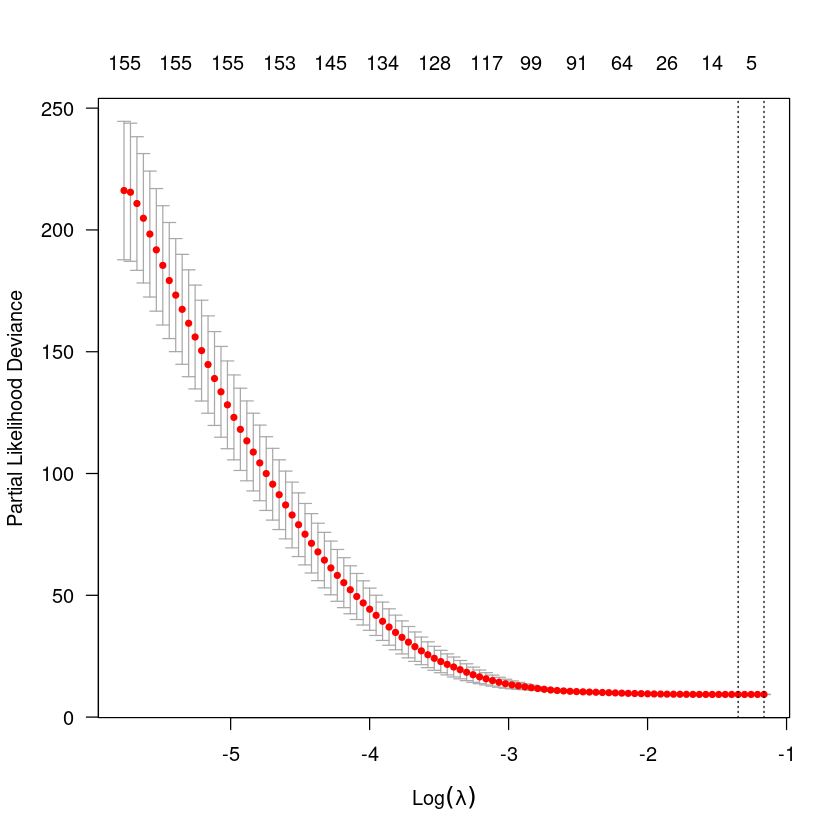

In [27]:
# lasso regression
uniCoxdata_res <- CoxData[,c(uniresult$gene,c("sample","OS.time","OS"))]
uniCoxdata_res <- uniCoxdata_res[uniCoxdata_res$OS.time != 0,]

# lasso
x_all <- subset(uniCoxdata_res, select = -c(sample,OS, OS.time)) 
# x_all <- x_all[,rownames()]
y_all <- subset(uniCoxdata_res, select = c(OS, OS.time))
cvfit = cv.glmnet(as.matrix(x_all),
                  Surv(y_all$OS.time,y_all$OS),nfold=10,family = "cox") 

png(filename = "03.lasso1.png", height = 450, width = 600)
plot(cvfit, las =1)
dev.off()
pdf(file = "03.lasso1.pdf", height = 5)
plot(cvfit, las =1)
dev.off()

fit <- glmnet(as.matrix(x_all), Surv(y_all$OS.time,y_all$OS), 
              family = "cox") 

png(filename = "03.lasso2.png", height = 450, width = 600)
plot(fit, xvar = "lambda",label = TRUE, las=1)
dev.off()
pdf(file = "03.lasso2.pdf", height = 5)
plot(fit, xvar = "lambda",label = TRUE, las=1)
dev.off()

coef.min = coef(cvfit, s = "lambda.min")  #Choose one from lambda.min & lambda.1se

active.min = which(coef.min@i != 0) ## fine the regression factor that not punished become zero

lasso_geneids <- coef.min@Dimnames[[1]][coef.min@i+1] ## get the genes name

target<- ID[ID$id %in% lasso_geneids,]  
targetGene <- CoxData[,c(c("sample","OS.time","OS"),target$id)]
colnames(targetGene)[4:8] <- target$gene


write.csv(targetGene, "targetGenes.csv")c

Call:
coxph(formula = Surv(OS.time, OS) ~ OSMR + `CTD-2035E11.4` + 
    AEBP1 + `RP11-309L24.6` + HOXC6, data = targetGene)

  n= 167, number of events= 137 

                   coef exp(coef) se(coef)     z Pr(>|z|)   
OSMR            0.22209   1.24869  0.08056 2.757  0.00583 **
`CTD-2035E11.4` 0.08944   1.09356  0.05761 1.553  0.12054   
AEBP1           0.08574   1.08952  0.07299 1.175  0.24011   
`RP11-309L24.6` 0.06989   1.07239  0.03233 2.162  0.03062 * 
HOXC6           0.10644   1.11231  0.04790 2.222  0.02627 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                exp(coef) exp(-coef) lower .95 upper .95
OSMR                1.249     0.8008    1.0663     1.462
`CTD-2035E11.4`     1.094     0.9144    0.9768     1.224
AEBP1               1.090     0.9178    0.9443     1.257
`RP11-309L24.6`     1.072     0.9325    1.0066     1.143
HOXC6               1.112     0.8990    1.0126     1.222

Concordance= 0.643  (se = 0.028 )
Likelihood ratio test= 42.17  

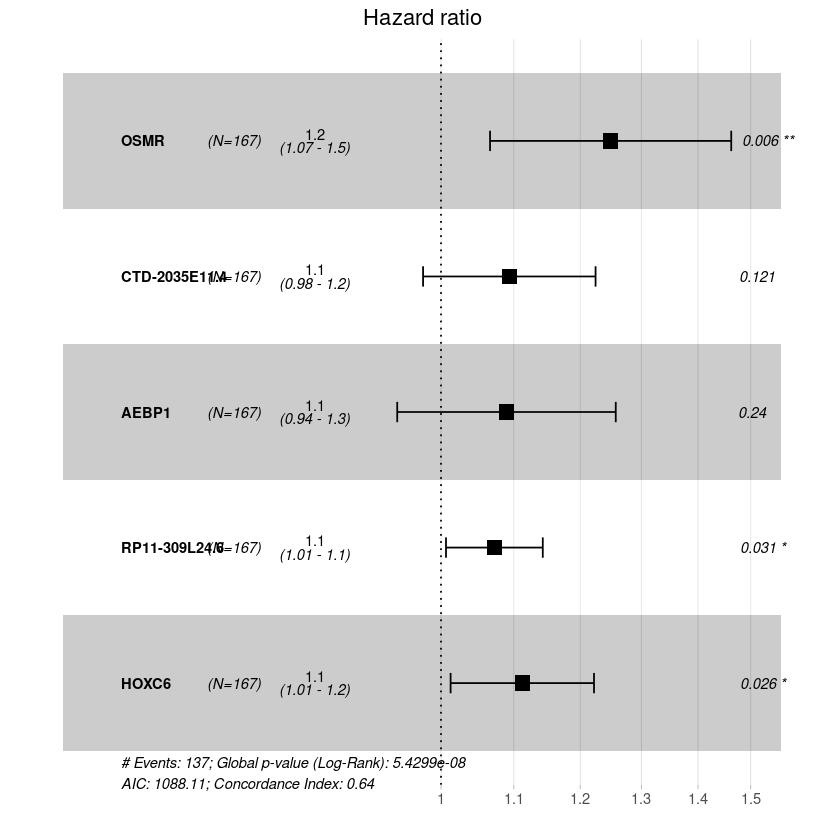

In [28]:
#multi factor regression model
model <- coxph( Surv(OS.time, OS) ~ OSMR+`CTD-2035E11.4`+AEBP1+`RP11-309L24.6`+HOXC6,
                data = targetGene )
summary(model)
#pdf("04.CoxModel.pdf")
ggforest(model,
         data = targetGene,
         main = "Hazard ratio", # Titled
         cpositions = c(0.08, 0.2, 0.35), #distance for the first three columns 
         fontsize = 0.8, # set fontsize
         refLabel = "reference",
         noDigits = 2) #set the digits to keep after the decimal point
#dev.off()c

In [29]:
#Survival analyse
Km_plot<- function(data,gene){
  #message(gene)
  data$group <- data[,gene]
  fit1 <- survfit(survobj~group,data=data)
  
  p<- ggsurvplot(fit1, data = data,
             surv.median.line = "hv", # Add medians survival
             # Change legends: title & labels
             legend.title = gene,
             legend.labs = c("high", "low"),
             # Add p-value and tervals
             pval = TRUE,
             conf.int = TRUE,
             # Add risk table
             risk.table = TRUE,
             tables.height = 0.2,
             tables.theme = theme_cleantable(),
             # Color palettes. Use custom color: c("#E7B800", "#2E9FDF"),
             # or brewer color (e.g.: "Dark2"), or ggsci color (e.g.: "jco")
             palette = c("lightblue", "lightgreen"),
             ggtheme = theme_bw() # Change ggplot2 theme
  )
  #pdf(paste("05.",gene,"_KM.pdf",sep = ""))
  print(p)
  #dev.off()

}


In [30]:
res.cut <- surv_cutpoint(targetGene, #dataframe
                         time = "OS.time", 
                         event = "OS", 
                         variables = c("OSMR","CTD-2035E11.4","AEBP1","RP11-309L24.6","HOXC6") #需要计算的数据列名
)


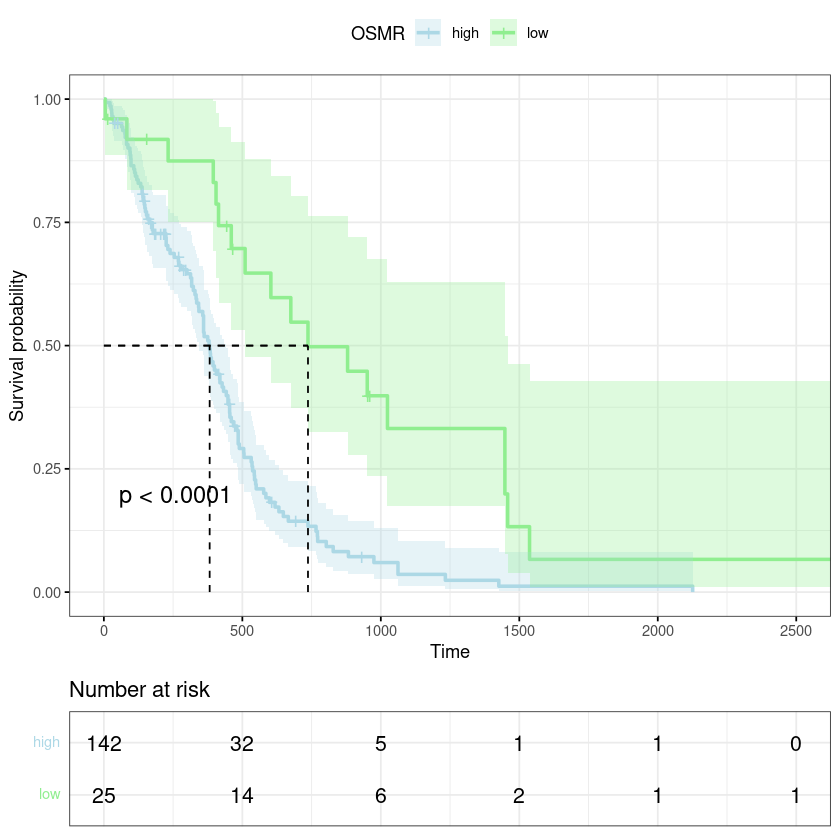

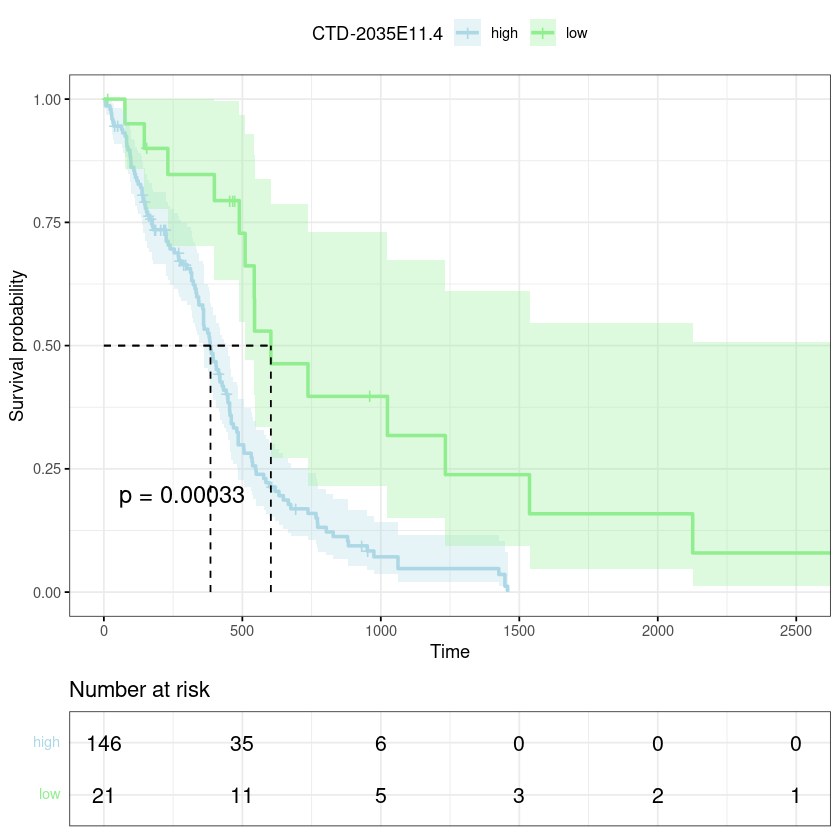

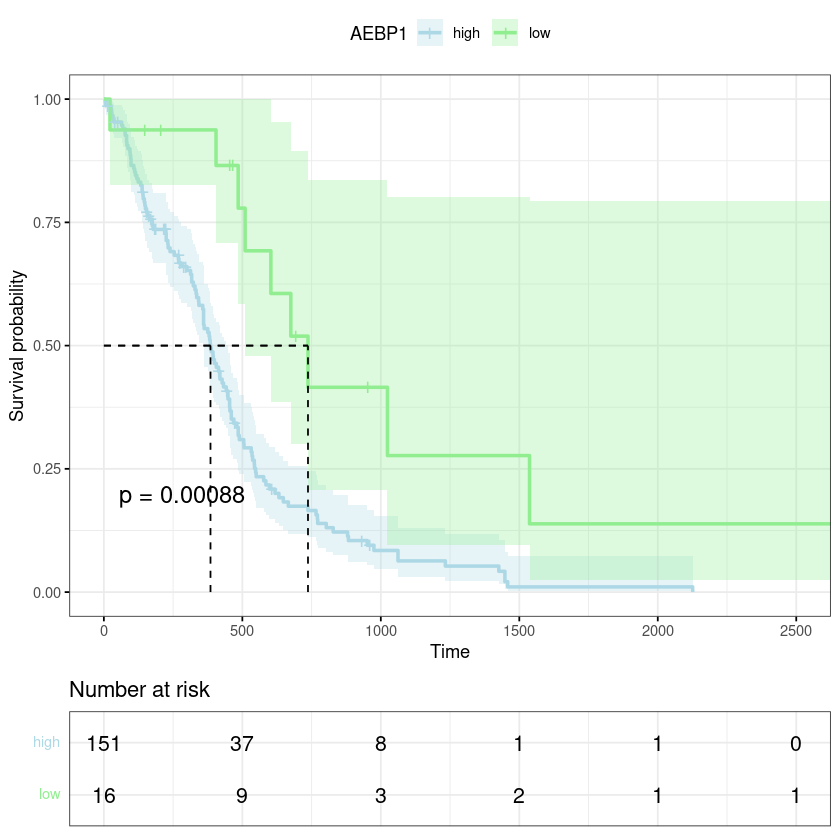

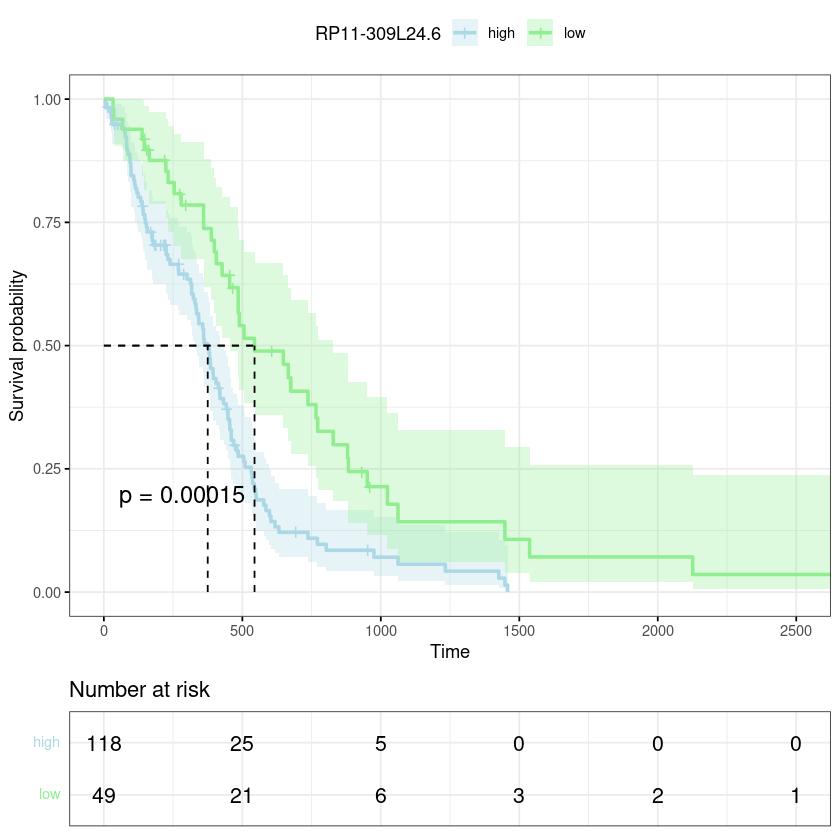

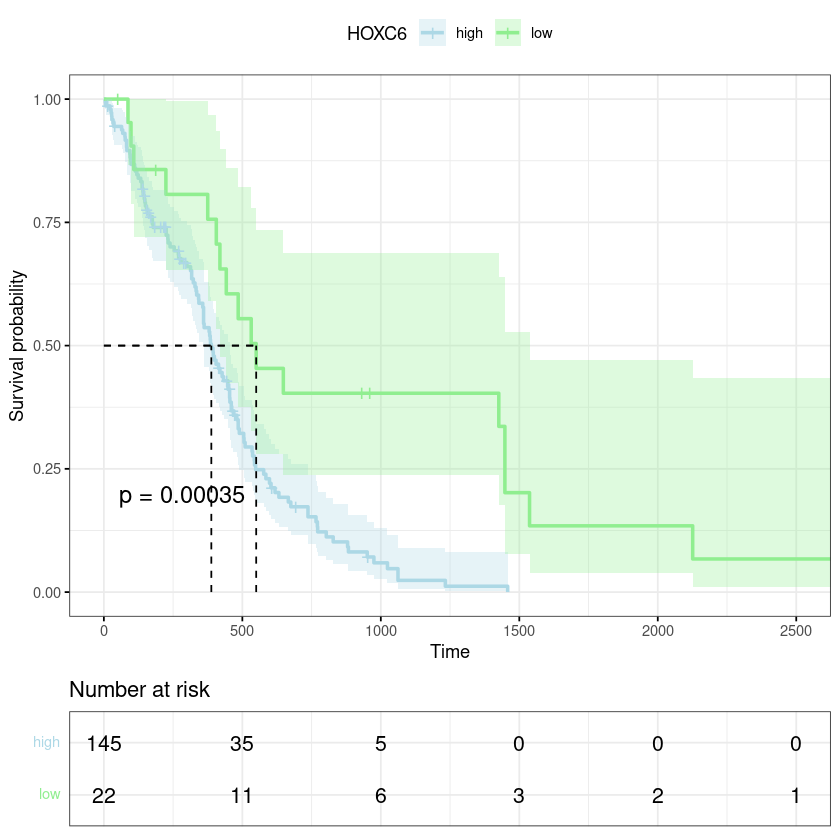

In [31]:
for (i in c(4:8)) {
  targetGene[,i] <-ifelse(targetGene[,i]>res.cut[[i-3]][["estimate"]][["estimated cutpoint"]],"high","low")
}

survobj <- with(targetGene, Surv(OS.time,OS))
Km_plot(targetGene,"OSMR")
Km_plot(targetGene,"CTD-2035E11.4")
Km_plot(targetGene,"AEBP1")
Km_plot(targetGene,"RP11-309L24.6")
Km_plot(targetGene,"HOXC6")